# <center>CITS5508 Lab sheet 3</center>

**Name: Alastair Mory**<br>
**Student number:** 21120848<br>
**Date created:** March 27th 2019<br>
**Last modified:** March 28th 2019<br>

In [138]:
from typing import (
    Any,
    Dict,
    List,
    Tuple,
    Union
)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    svm,
    tree
)

Array2D = Union[List[List], np.ndarray, pd.DataFrame]
Array1D = Union[List, pd.core.series.Series]

## Project 1
Decision tree and support vector machine classifiers will be compared on a classification task involving cellular localisation site of proteins from E. coli bacteria. The data set was obtained [here](https://archive.ics.uci.edu/ml/datasets/ecoli).

The data set file is unlabeled, however a data set [description file](https://archive.ics.uci.edu/ml/datasets/ecoli) lists both the attribute and class label information:


Attribute Information:

  1.  Sequence Name: Accession number for the SWISS-PROT database
  2.  mcg: McGeoch's method for signal sequence recognition.
  3.  gvh: von Heijne's method for signal sequence recognition.
  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
       Binary attribute.
  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
	   Binary attribute.
  6.  aac: score of discriminant analysis of the amino acid content of
	   outer membrane and periplasmic proteins.
  7. alm1: score of the ALOM membrane spanning region prediction program.
  8. alm2: score of ALOM program after excluding putative cleavable signal
	   regions from the sequence.
       

Class Distribution (the class is the localisation site):

      cp  (cytoplasm)                                    143
      im  (inner membrane without signal sequence)        77               
      pp  (perisplasm)                                    52
      imU (inner membrane, uncleavable signal sequence)   35
      om  (outer membrane)                                20
      omL (outer membrane lipoprotein)                     5
      imL (inner membrane lipoprotein)                     2
      imS (inner membrane, cleavable signal sequence)      2

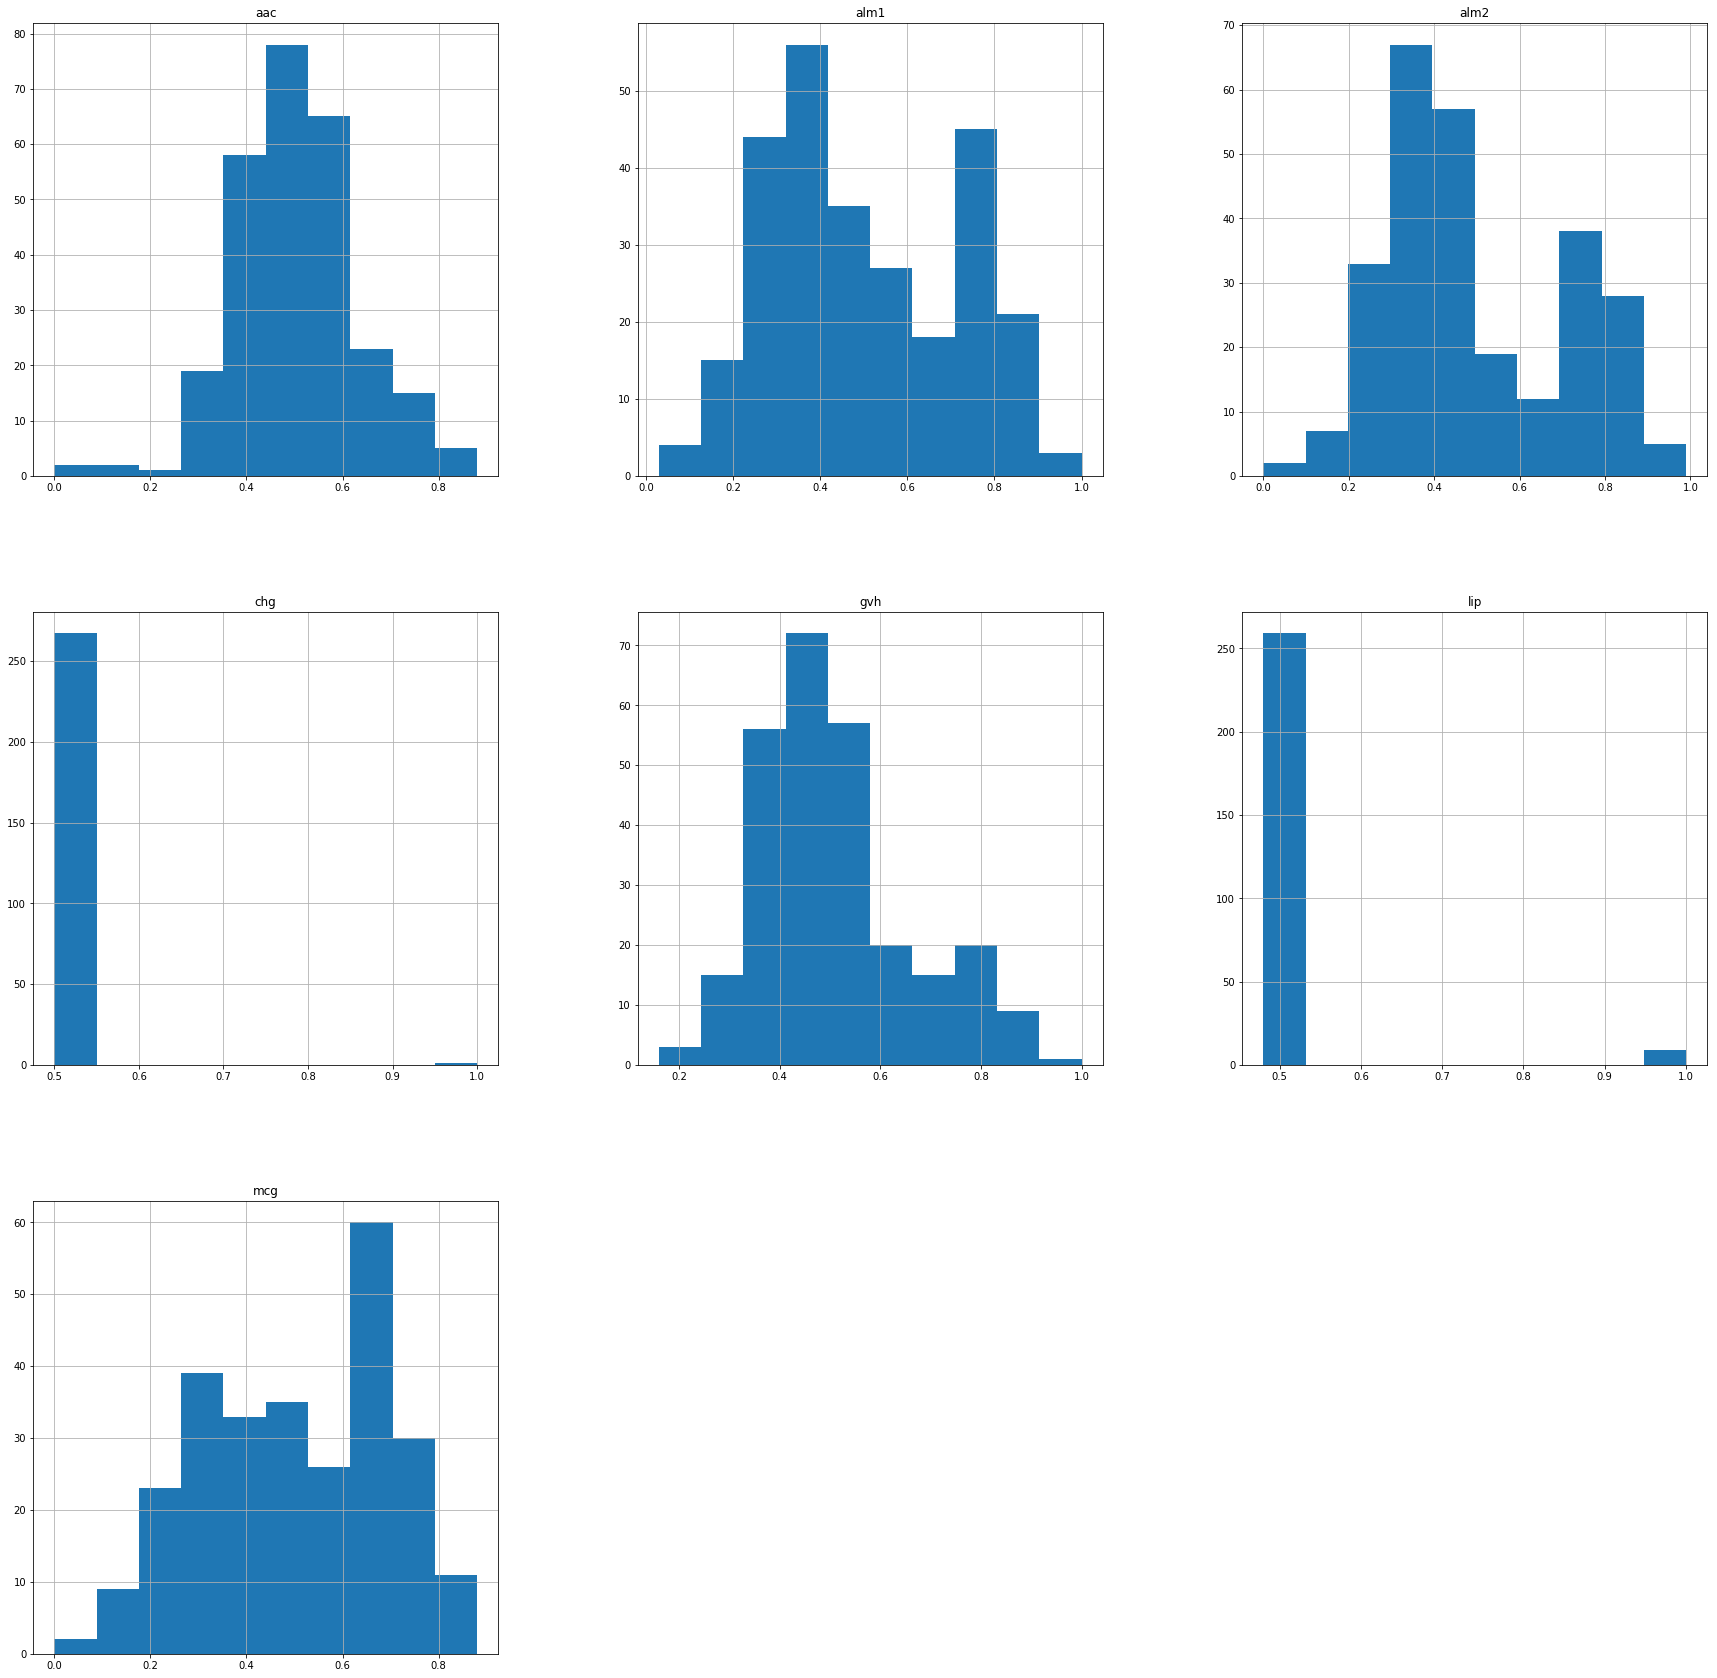

In [139]:
# Use the names given to the attriubtes above for column headers.
HEADER = ['Sequence Name', 'mcg', 'gvh', 'lip',
          'chg', 'aac', 'alm1', 'alm2', 'class']

data_file = pd.read_csv('./ecoli.data', delim_whitespace=True, names=HEADER)

# Immediately split our data to avoid a data snooping bias.
train, test = model_selection.train_test_split(data_file,
                                               test_size=0.2,
                                               train_size=0.8)
train = train.reset_index()
test = test.reset_index()

# Need to remove classes with < 10 members:
CLASSES_TO_DROP = ['omL', 'imL', 'imS']
CLASS_LABELS = ['cp', 'im', 'pp', 'imU', 'om']

train.hist(column=HEADER[1:-1], layout=(3,3), figsize=(30,30))
plt.show()

In [140]:
train.head()

,index,Sequence Name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,29,DDLA_ECOLI,0.43,0.39,0.48,0.5,0.47,0.31,0.41,cp
1,72,NHAR_ECOLI,0.37,0.50,0.48,0.5,0.42,0.36,0.45,cp
2,105,RNC_ECOLI,0.26,0.50,0.48,0.5,0.44,0.32,0.41,cp
3,203,PTOA_ECOLI,0.35,0.51,0.48,0.5,0.61,0.71,0.74,im
4,112,SYC_ECOLI,0.35,0.34,0.48,0.5,0.46,0.30,0.27,cp


In [141]:
"""
Sequence Name is a string, and it looks like every row has a different
string value so it probably isn't useful to the classifiers.
"""
COLUMNS_TO_DROP = ['Sequence Name']

In [142]:
"""Checking distributions of numerical features"""
train.describe()

,index,mcg,gvh,lip,chg,aac,alm1,alm2
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,170.847015,0.503284,0.508843,0.497463,0.501866,0.502388,0.500634,0.495746
std,97.543743,0.191877,0.151241,0.093854,0.030542,0.126415,0.215333,0.213422
min,1.000000,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,86.500000,0.340000,0.407500,0.480000,0.500000,0.420000,0.330000,0.340000
50%,172.500000,0.510000,0.485000,0.480000,0.500000,0.500000,0.450000,0.430000
75%,256.250000,0.660000,0.570000,0.480000,0.500000,0.570000,0.710000,0.712500
max,335.000000,0.880000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


In [143]:
"""
The 'lip' and 'chg' features both appear to have only one value (0.48
& 0.5 respectively). We can confirm this by checking the set of values
these columns contain.
"""
print(f"lip values: {set(list(train['lip']))}")
print(f"chg values: {set(list(train['chg']))}")


lip values: {0.48, 1.0}
chg values: {0.5, 1.0}


In [144]:
"""
From the above it's clear 'chg' won't help training the classifiers as it
only contains one value. 'lip' might be useful as a binary feature, but
this will depend on its distribution.
"""
COLUMNS_TO_DROP.append('chg')

lip048_count = list(train['lip']).count(0.48)
lip100_count = list(train['lip']).count(1.00)
print(f"Amount of instances with 'lip' = 0.48: {lip048_count}")
print(f"Amount of instances with 'lip' = 1.00: {lip100_count}")

Amount of instances with 'lip' = 0.48: 259
Amount of instances with 'lip' = 1.00: 9


In [145]:
"""
Of the classes where 'lip' parameter is not equal to 0.48, about half
have less than 10 instances so will be deleted anyway. Hence the
classifiers will probably perform better without the 'lip' column.
"""
print([row['class'] for i, row in train.iterrows() if row['lip'] != 0.48])
COLUMNS_TO_DROP.append('lip')

['imL', 'omL', 'imU', 'omL', 'om', 'omL', 'im', 'omL', 'omL']


In [146]:
"""
Because it's important to preprocess both the training and test data in
exactly the same way, here's a function that does the preprocessing:
"""
print(CLASSES_TO_DROP)
print(COLUMNS_TO_DROP)
def preprocess_data(data: pd.DataFrame,
                    drop_classes: List[str] = CLASSES_TO_DROP,
                    drop_columns: List[str] = COLUMNS_TO_DROP
                    ) -> Tuple[Series, Array]:
    """
    Drop rows containing data for classes in drop_classes and remove columns
    contained in drop_columns, returns the data's class labels (y) and the
    remaining data as x.
    """
    drop_rows = []
    for i in range(len(data)):
        if data.loc[i, 'class'] in drop_classes:
            drop_rows.append(i)
    data = data.drop(index=drop_rows)
    data.reset_index()
    y = data['class']
    if 'class' not in drop_columns:
        drop_columns.append('class')
    X = data.drop(columns=drop_columns)
    return y, X


train_y, train_X = preprocess_data(train)
test_y, test_X = preprocess_data(test)

['omL', 'imL', 'imS']
['Sequence Name', 'chg', 'lip']


In [147]:
def test_classifier(clf: Any,  # Can be any SKLearn classifier object
                    train_X: Array, train_y: Series,
                    test_X: Array, test_y: Series,
                    normalise_data: bool = False,
                    f1_average_method: str = 'weighted'
                    ) -> Tuple[Array, float, float]:
    """
    Fit clf against training data (train_X & train_y), run predictions on test
    data (test_X) and compare predictions to test_y, return confusion matrix
    of results.
    """
    if normalise_data:
        scaler = preprocessing.StandardScaler().fit(train_X)
        train_X = scaler.transform(train_X)
        test_X = scaler.transform(test_X)
    # Do the classification
    pred_y = clf.fit(train_X, train_y).predict(test_X)

    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(test_y, pred_y)
    # Various Metrics
    accuracy = metrics.accuracy_score(test_y, pred_y)
    correct_count = metrics.accuracy_score(test_y, pred_y, normalize=False)
    error_count = len(test_y) - correct_count
    f1 = metrics.f1_score(test_y, pred_y, average=f1_average_method)

    results = {
        'y_true': test_y,
        'y_pred': pred_y,
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'f1': f1,
        'correct': correct_count,
        'errors': error_count
    }
    return results

In [149]:
SVM_clf = svm.SVC()

DT_clf = tree.DecisionTreeClassifier()

svm_unnorm_results = test_classifier(SVM_clf,
                                     train_X, train_y,
                                     test_X, test_y)

svm_norm_results = test_classifier(SVM_clf,
                                   train_X, train_y,
                                   test_X, test_y,
                                   normalise_data=True)

dt_results = test_classifier(DT_clf,
                             train_X, train_y,
                             test_X, test_y)


/home/alastair/Documents/ml/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/alastair/Documents/ml/env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alastair/Documents/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/alastair/Documents/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [150]:
def print_result_metrics(svm, svm_norm, dt):
    sua, suf = svm['accuracy'], svm['f1']
    sna, snf = svm_norm['accuracy'], svm_norm['f1']
    dta, dtf = dt['accuracy'], dt['f1']
    sue, sne, dte = svm['errors'], svm_norm['errors'], dt['errors']
    print("            | Accuracy | F1 Score | Errors")
    print(f"SVM, unnorm |  {sua:.4f}  |   {suf:.2f}   | {sue}")
    print(f"SVM, norm   |  {sna:.4f}  |   {snf:.2f}   | {sne}")
    print(f"DT          |  {dta:.4f}  |   {dtf:.2f}   | {dte}")


print_result_metrics(svm_unnorm_results,
                     svm_norm_results,
                     dt_results)



            | Accuracy | F1 Score | Errors
SVM, unnorm |  0.9851  |   0.98   | 1
SVM, norm   |  0.9851  |   0.98   | 1
DT          |  0.9851  |   0.98   | 1


In [148]:
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyright (c) 2007–2019 The scikit-learn developers.
    Used under license.
    """
    cm = confusion_matrix
    if not title:
        title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

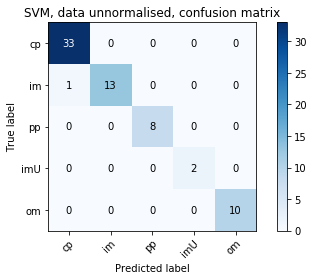

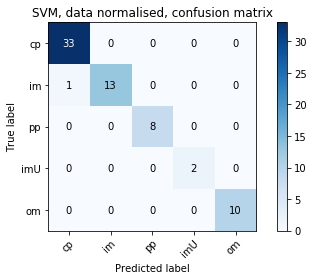

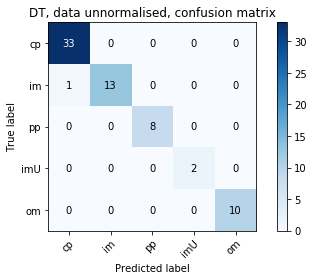

In [153]:
plot_confusion_matrix(svm_unnorm_results['confusion_matrix'], CLASS_LABELS,
                      title="SVM, data unnormalised, confusion matrix")

plot_confusion_matrix(svm_unnorm_results['confusion_matrix'], CLASS_LABELS,
                      title="SVM, data normalised, confusion matrix")

plot_confusion_matrix(svm_unnorm_results['confusion_matrix'], CLASS_LABELS,
                      title="DT, data unnormalised, confusion matrix")

plt.show()

## Project 2

